In [1]:
%load_ext autoreload
import ais_predict.datasets.bigquery as bq
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (14, 10)

<AxesSubplot:>

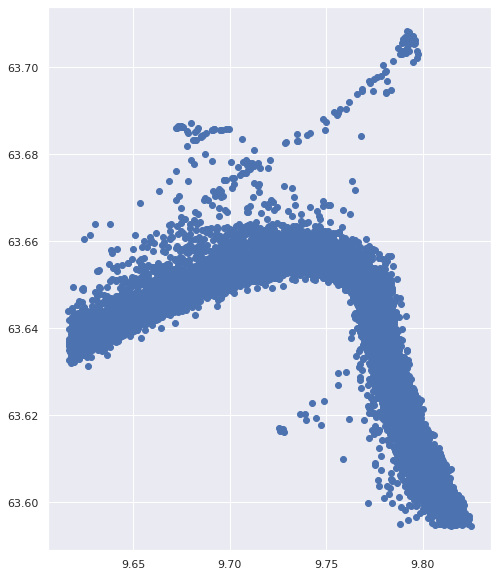

In [2]:
%autoreload
df = bq.download(limit=10000, lead=1)
df.plot()
#plt.xlim([200, 250])
#plt.ylim([25, 75])

<AxesSubplot:>

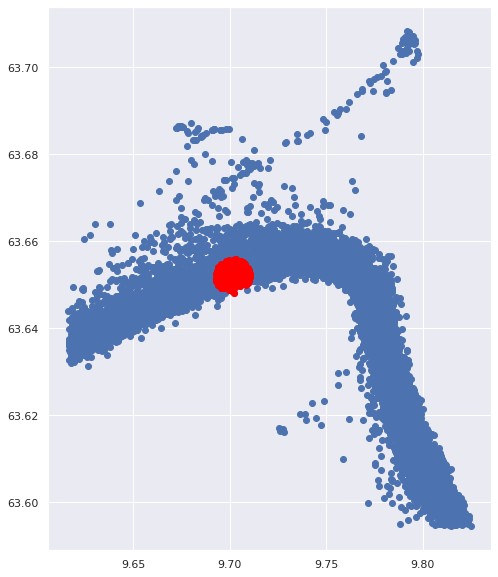

In [4]:
center = df.position.sample().to_crs(epsg=3857).to_numpy()[0]
subset = df.to_crs(epsg=3857).within(center.buffer(1e3))
ax = df.plot()
df[subset].plot(ax=ax, color="red")

In [5]:
%autoreload
within = gpd.GeoSeries(center.buffer(1e3, resolution=4), crs="epsg:3857").to_crs("wgs84").to_numpy()[0]
d = bq.download(lead=10, within=within, limit=None)

In [6]:
mmsi_grouping = d.groupby("mmsi")
groups = tuple(mmsi_grouping.groups.keys())
train_mmsi = groups[::2]
test_mmsi = groups[1::2]



train_df = d.loc[d.mmsi.isin(train_mmsi)].copy()
test_df = d.loc[d.mmsi.isin(test_mmsi)].copy()

# Make sure no leakage between test and training
assert len(set(train_mmsi).intersection(test_mmsi)) == 0

<AxesSubplot:>

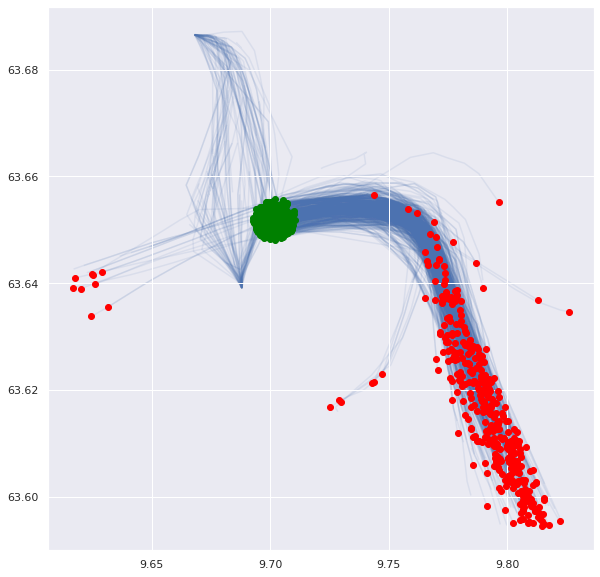

In [7]:
from shapely.geometry import Point, LineString
import geopandas as gpd
cols = d.columns[d.columns.str.match("position")]
p = gpd.GeoSeries(d[cols].apply(lambda x: LineString(x.tolist()), axis=1))
temp = gpd.GeoDataFrame({"lines": p, "cog": d.cog}, geometry="lines")
ax = temp.plot(alpha=0.1, zorder=0)
test_df[cols[0]].plot(ax=ax, color="green", zorder=1)
test_df[cols[-1]].plot(ax=ax, color="red", zorder=1)


In [8]:
def limits(*args):
    args = [a.reshape((-1, 2)) for a in args]
    temp = np.concatenate(args)
    min = np.min(temp, axis=0)
    max = np.max(temp, axis=0)
    return tuple(zip(min, max))

(500,)


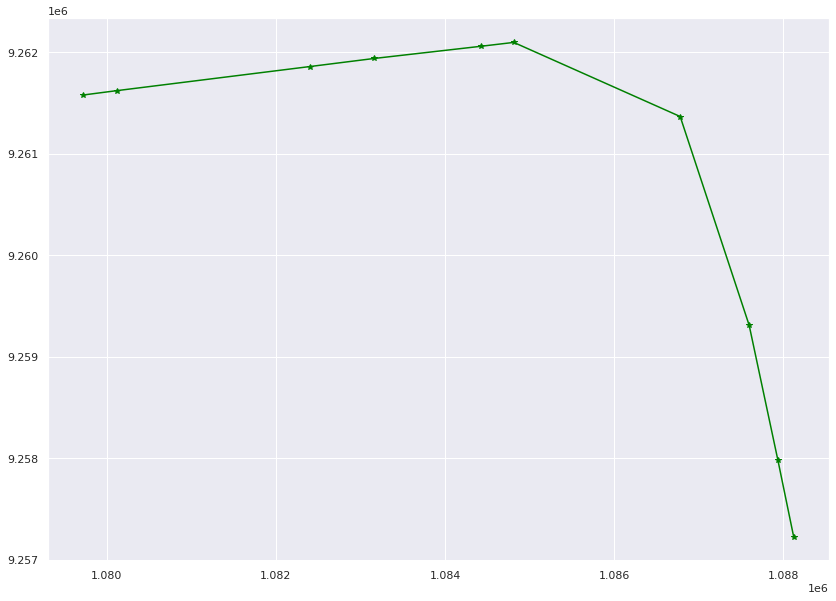

In [9]:
%autoreload
import ais_predict.trajpred.dyngp as dyngp
import numpy as np
init = test_df.sample(1)
train_df["cog_dist"] = abs(train_df.cog.to_numpy() - init.cog.to_numpy())
train_df["sog_dist"] = abs(train_df.sog.to_numpy() - init.sog.to_numpy())
train_df_dir = train_df.loc[train_df["cog_dist"] < 20]
train_df_dir = train_df_dir.loc[train_df_dir["sog_dist"] < 2]
train_df_dir = train_df_dir.sort_values(by="sog_dist")
train_x, train_y, train_t = dyngp.samples_from_lag_n_df(train_df_dir, 10)
# Remove any non-moving samples
msk = np.linalg.norm(train_y, axis=1) > 1
train_x, train_y, train_t = train_x[msk], train_y[msk], train_t[msk]

# Pick first (assumed best) 500 samples - reduce computation time
train_t = train_t[:500]
train_x = train_x[:500]
train_y = train_y[:500]

print(train_t.shape)

xlim, ylim = limits(train_x)
init_x, init_y, init_t = dyngp.samples_from_lag_n_df(init, 10)
plt.plot(*init_x.T, "*-", color="green")


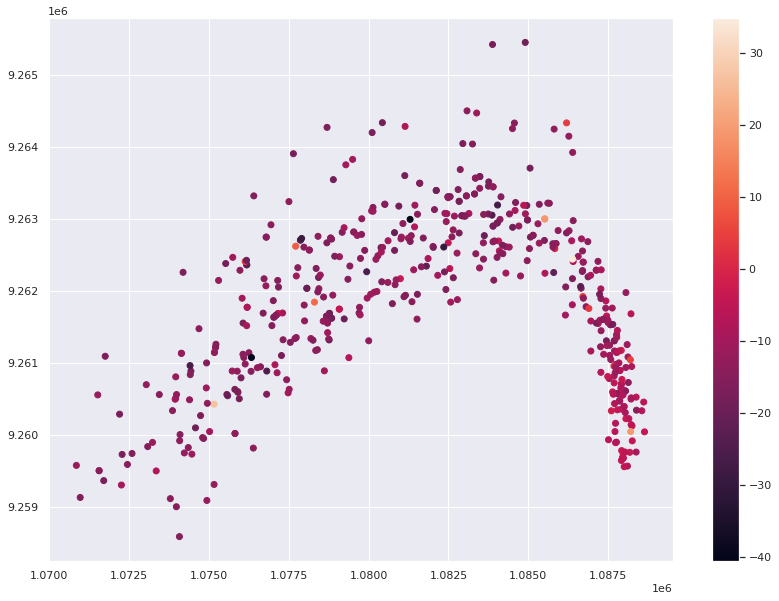

In [9]:
plt.scatter(*train_x.T, c=train_y[:, 0])
plt.colorbar()

[ 8.22566367 -6.51104417] [ 9.34633699 10.25218189]
/home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
0.9999999998738591
0.4954111247775118


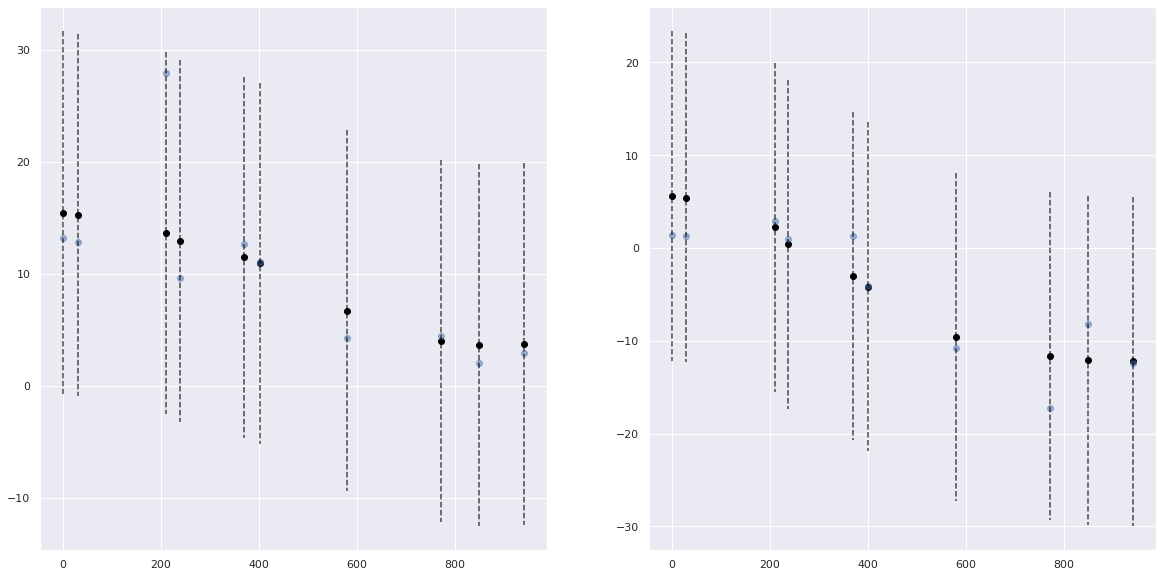

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern 
kernel =  ConstantKernel() * RBF() + ConstantKernel() * RBF() + WhiteKernel()

t = test_df.copy()
t["cog_dist"] = abs(t.cog.to_numpy() - init.cog.to_numpy())
t["sog_dist"] = abs(t.sog.to_numpy() - init.sog.to_numpy())
t = t.loc[t["cog_dist"] < 20]
t = t.loc[t["sog_dist"] < 2]
t = t.sort_values(by="sog_dist")
test_x, test_y, test_t = dyngp.samples_from_lag_n_df(t, 10)
msk = np.linalg.norm(test_y, axis=1) > 1
test_x, test_y, test_t = test_x[msk], test_y[msk], test_t[msk]

# Pick first (assumed best) 500 samples - reduce computation time
test_t = test_t[:500]
test_x = test_x[:500]
test_y = test_y[:500]


m = train_y.mean(axis=0)
n = train_y.std(axis=0)

print(m, n)

gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)#, alpha=20)
gp.fit(train_x, (train_y-m) / n)
print(gp.score(train_x, (train_y-m)/n))
print(gp.score(test_x, (test_y-m)/n))
params_mle = gp.kernel_.get_params()

p, s = gp.predict(init_x, return_std=True)
p = p*n + m
s = s[np.newaxis, ..., np.newaxis] * n

ci = np.vstack([
    p + 2*s,
    p - 2*s
])


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(init_t, p[:, 0], color="black")
plt.plot(init_t.reshape((1, -1)).repeat(2, axis=0), ci[:, :, 0], "--", color="black", alpha=0.7)
plt.scatter(init_t, init_y[:, 0], alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(init_t, p[:, 1], color="black")
plt.scatter(init_t, init_y[:, 1], alpha=0.5)
_ = plt.plot(init_t.reshape((1, -1)).repeat(2, axis=0), ci[:, :, 1], "--", color="black", alpha=0.7)


In [12]:
params_mle

{'k1': 0.657**2 * RBF(length_scale=3.92e+03) + 0.858**2 * RBF(length_scale=2.61),
 'k2': WhiteKernel(noise_level=1e-05),
 'k1__k1': 0.657**2 * RBF(length_scale=3.92e+03),
 'k1__k2': 0.858**2 * RBF(length_scale=2.61),
 'k1__k1__k1': 0.657**2,
 'k1__k1__k2': RBF(length_scale=3.92e+03),
 'k1__k1__k1__constant_value': 0.4311811932732862,
 'k1__k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k1__k2__length_scale': 3921.28029650662,
 'k1__k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k1__k2__k1': 0.858**2,
 'k1__k2__k2': RBF(length_scale=2.61),
 'k1__k2__k1__constant_value': 0.7368471771291241,
 'k1__k2__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__k2__length_scale': 2.611484134094284,
 'k1__k2__k2__length_scale_bounds': (1e-05, 100000.0),
 'k2__noise_level': 9.999999999999997e-06,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

In [14]:
%autoreload
start = init_x[0].reshape((1, 2))
print(start)
params = dyngp.Params(
    lengthscales = np.array([params_mle["k1__k1__k2"].length_scale, params_mle["k1__k2__k2"].length_scale]),
    sigmas = np.array([params_mle["k1__k1__k1"].constant_value, params_mle["k1__k2__k1"].constant_value]),
    noise = params_mle["k2"].noise_level,
    clutter_rate = 1e-4,
    R = 1000**2 * np.eye(2),
    gate_size = 2,
    p_d = 0.80,
)

dgp = dyngp.DynGP(train_x, train_y, params, normalize_y=True)

f, var, n_measurements = dgp.kalman(start, end_time=init_t[-1],dt=10, pdaf_update=True, return_gated=True)
f_no_upd, var_no_upd = dgp.kalman(start, end_time=init_t[-1], dt=10, pdaf_update=False)
xlim, ylim = limits(init_x, train_x)
#ylim = (min(np.min(init_x[:, 1]), np.min(f[:, :, 1])), max(np.max(init_x[:, 1]), np.max(f[:, :, 1])))
#xlim = (min(np.min(init_x[:, 0]), np.min(f[:, :, 0])), max(np.max(init_x[:, 0]), np.max(f[:, :, 0])))
#ylim = (min(np.min(init_x[:, 1]), np.min(f[:, :, 1])), max(np.max(init_x[:, 1]), np.max(f[:, :, 1])))
plt.xlim(xlim)
plt.ylim(ylim)

dgp.plot_uncertianty_grid(xlim=xlim, ylim=ylim, size=(40, 40))
#plt.scatter(*train_y[:, :2].T, color="black", alpha=0.4)

#plt.scatter(*test_x.T, color="red", alpha=0.2)
plt.plot(*f.T, alpha=0.9, linewidth=4, label="With PDAF", color="blue")
plt.plot(*f_no_upd.T, alpha=0.9, linewidth=4, label="Without PDAF", color="red")
plt.scatter(*init_x.T, color="yellow", label="Ground Truth", zorder=3)
plt.legend()
plt.tight_layout()
#plt.gca().set_aspect("equal")
plt.savefig("gp_ekf.png")


[[1079725.03323338 9261579.95071554]]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /home/haavard/ais-predict/ais_predict/trajpred/dyngp.py (45)

File "ais_predict/trajpred/dyngp.py", line 45:
def kernel_rbf(X1: np.ndarray, X2: np.ndarray, sigma: float, lengthscale: float) -> np.ndarray:
    K = np.empty((X2.shape[0], X1.shape[0]))
    ^

This error may have been caused by the following argument(s):
- argument 2: Cannot determine Numba type of <class 'sklearn.gaussian_process.kernels.ConstantKernel'>


In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
s = np.sqrt(np.diagonal(var, axis1=-2, axis2=-1)).squeeze()
s_no_upd = np.sqrt(np.diagonal(var_no_upd, axis1=-2, axis2=-1)).squeeze()
t = np.linspace(0, init_t[-1], s.shape[0])
ci_high = f + 3 * s
ci_low = f - 3 * s
ci_high_no_upd = f_no_upd + 3 * s_no_upd
ci_low_no_upd = f_no_upd - 3 * s_no_upd
for d in range(f.shape[-1]):
    ax[d].scatter(train_t, train_x[:, d], alpha=0.2)
    ax[d].plot(t, f[0, :, d], color="blue", label="With PDAF")
    ax[d].fill_between(t, ci_high[0, :, d], ci_low[0, :, d], alpha=0.2, color="blue")
    ax[d].plot(t, ci_high[0, :, d], color="blue", alpha=0.3)
    ax[d].plot(t, ci_low[0, :, d], color="blue", alpha=0.3)
    ax[d].plot(t, f_no_upd[0, :, d], color="red", label="Without PDAF")
    ax[d].fill_between(t, ci_high_no_upd[0, :, d], ci_low_no_upd[0, :, d], alpha=0.2, color="red")
    ax[d].plot(t, ci_high_no_upd[0, :, d], color="red", alpha=0.3)
    ax[d].plot(t, ci_low_no_upd[0, :, d], color="red", alpha=0.3)
    ax[d].set_xlabel("Time [s]")
    ax[d].set_ylabel("Position")
    ax[d].scatter(init_t, init_x[:, d], label="Ground Truth", color="yellow")
    ax[d].legend()
ax[0].set_title("Position X")
ax[1].set_title("Position Y")
plt.tight_layout()
plt.savefig("gp_ekf_unc.png")


NameError: name 'var' is not defined

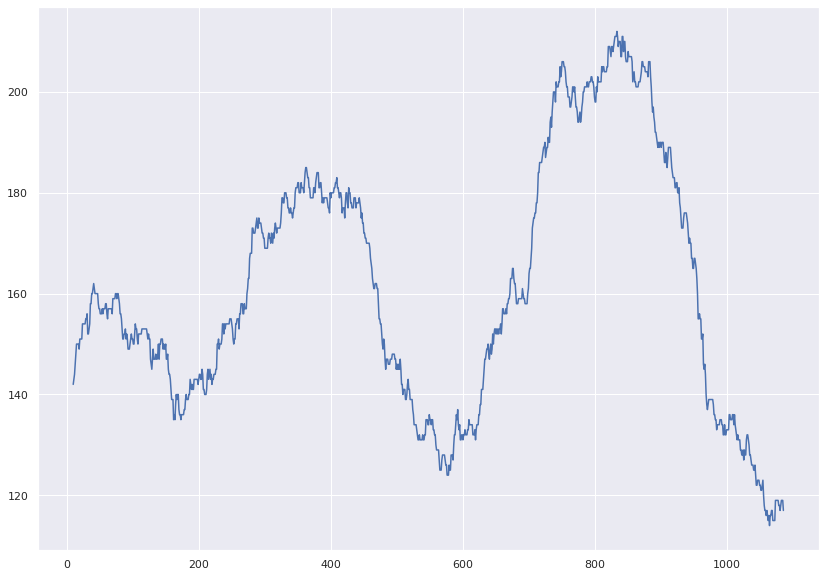

In [71]:
plt.plot(t[10:], n_measurements.squeeze()[10:])

In [31]:
%autoreload
import pandas as pd

def run_group(test: gpd.GeoDataFrame):
    sog = test.sog.mean()
    cog = test.cog.mean()
    cog_dist: pd.Series = abs(train_df.cog - cog)
    cog_msk: pd.Series = cog_dist < 10 # 10 deg
    sog_dist = abs(train_df.sog - sog)
    sog_msk = sog_dist < 1 # 1 knot
    msk = cog_msk & sog_msk
    train = train_df.loc[msk]

    cog_dist = cog_dist.loc[msk]
    sog_dist = sog_dist.loc[msk]

    sog_dist = sog_dist.sort_values()

    train = train.loc[sog_dist.index]

    if len(train.index) < 5:
        raise RuntimeError("Not enough training data")

    train_x, train_y, train_t = dyngp.samples_from_lag_n_df(train, 10)

    train_x = train_x[:500]
    train_y = train_y[:500]
    train_t = train_t[:500]


    kernel =  ConstantKernel(1000) * RBF(length_scale=2000)

    n = train_y.var()
    gp = GaussianProcessRegressor(kernel, alpha=n)#, alpha=20)
    gp.fit(train_x, train_y)
    params = gp.kernel_.get_params()
    print(params)

    
    dpg = dyngp.DynGP(train_x, train_y)
    dgp.lengthscale = params["k2"].length_scale
    dgp.sigma = np.sqrt(params["k1"].constant_value)
    dgp.noise = np.sqrt(n)
    dgp.clutter_rate = 1e-4
    dgp.R = 1000**2 * np.eye(2)
    dgp.p_d = 0.90


    init = np.empty((len(test.index), 2))
    for i in range(init.shape[0]):
        init[i], _, _ = dyngp.samples_from_lag_n_df(test.iloc[i:i+1], 1)

    test_x, test_y, test_t = dyngp.samples_from_lag_n_df(test, 10, flatten=False)

    dt = 1
    pred_x, pred_s = dgp.kalman(init, end_time=np.max(test_t), dt=dt)

    t = np.arange(pred_x.shape[1]) * dt
    
    # Remove first, known point
    #test_x = test_x[1:]
    #test_t = test_t[1:]

    dist_t = abs(t[np.newaxis, np.newaxis, ...] - test_t[...,np.newaxis])
    ti = np.argmin(dist_t, axis=2)[...,np.newaxis]
    dist = np.take_along_axis(pred_x, ti, axis=1) - test_x
    dist = dist[:, 1:, :]
    dist = np.linalg.norm(dist, axis=2)
    return dist.shape[0], dist.mean(), np.take_along_axis(dist_t, ti, axis=2).max()




        




d = test_df.copy()
d["sog_grp"] = d.sog.apply(np.round).astype(np.int16)
d["cog_grp"] = d.cog.divide(5.0).apply(np.round).astype(np.int16)

grp = d.groupby(["sog_grp", "cog_grp"])
for name, grp in grp:
    try:
        print(run_group(grp))
    except Exception as e:
        print("error", e)
    
    
    
    


(2, 957.1010587163354, 4.0)
error Not enough training data
error Not enough training data
(1, 4012.908694927625, 3.0)
(2, 1450.3511151090418, 4.0)
error Not enough training data
(3, 2801.787772328171, 5.0)
(2, 2221.6666687330126, 5.0)
(9, 5985.119665534809, 5.0)
(7, 8526.705743799392, 5.0)
(2, 6496.4589339785, 5.0)
(10, 3527.514479238433, 5.0)
(4, 7648.063403328711, 4.0)
(1, 3254.309001196077, 3.0)
(2, 5846.186710677925, 5.0)
(4, 3795.0859318293005, 5.0)
/home/haavard/.pyenv/versions/3.9.5/envs/master-thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
(8, 4836.783253490532, 5.0)
(17, 3518.9660814887015, 5.0)
/home/haavard/.pyenv/versions/3.9.5/envs/master-thesis/lib/python3.9/site-packages/sklearn/gaussian_proc

KeyboardInterrupt: 

In [30]:
train_df.iloc[0:1]

,mmsi,timestamp,cog,heading,sog,position,timestamp_1,cog_1,heading_1,sog_1,...,heading_9,sog_9,position_9,timestamp_10,cog_10,heading_10,sog_10,position_10,cog_dist,sog_dist
0,209432000,2015-12-01 13:16:44.999990+00:00,66.3,64,11.915435,POINT (9.68474 63.64955),2015-12-01 13:17:35.000016+00:00,69.1,68,11.699529,...,167,12.329911,POINT (9.78408 63.62494),2015-12-01 13:41:04.999977+00:00,164.7,163,12.665246,POINT (9.79301 63.60919),3.7,1.824622
